In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import scipy.stats as sps


In [30]:
# importation du datasets et definitions des colonnes
dataset = pd.read_csv('./datasets/mushrooms1.csv',header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']

In [31]:
dataset.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
5819,p,f,s,w,t,f,f,c,b,p,...,f,w,w,p,w,o,p,h,s,g
997,e,x,y,y,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
4425,e,f,f,e,t,n,f,c,b,n,...,s,g,g,p,w,o,p,k,y,d
5988,p,f,s,g,t,f,f,c,b,h,...,s,w,w,p,w,o,p,h,s,g
1961,e,x,f,g,t,n,f,c,b,u,...,s,w,g,p,w,o,p,k,y,d


Calculer l'entropie avec la formule
$$\frac{1}{X}\sum_{i=1}^n -x_i * \log x_i$$

In [3]:
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) 
                      for i in range(len(elements))])
    return entropy


In [36]:
# calculer le gain
def InfoGain(data,split_attribute_name,target_name="target"):
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    ##Calculate the entropy of the dataset
    #Calculate the values and the corresponding counts for the split attribute
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    print(len(vals))
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain


In [40]:
def ID3(data,originaldata,features,target_attribute_name="target",parent_node_class = None):
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    elif len(features) ==0:
        return parent_node_class
    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        features = np.random.choice(features,size=np.int64(np.sqrt(len(features))),replace=False)
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features] 
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        features = [i for i in features if i != best_feature]
        tree = {best_feature:{}}
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
        return(tree)

In [7]:
def predict(query,tree,default = 'p'):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [12]:
def RandomForest_Train(dataset,number_of_Trees):
    #Create a list in which the single forests are stored
    random_forest_sub_tree = []
    #Create a number of n models
    for i in range(number_of_Trees):
    #Create a number of bootstrap sampled datasets from the original dataset
        bootstrap_sample = dataset.sample(frac=1,replace=True)
    #Create a training and a testing datset by calling the train_test_split function
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1]
    #Grow a tree model for each of the training data
    #We implement the subspace sampling in the ID3 algorithm itself. Hence take a look at the ID3 algorithm above!
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=['target'],axis=1).columns))
    return random_forest_sub_tree


In [8]:
def train_test_split(dataset):
    training_data = dataset.iloc[:round(0.75*len(dataset))].reset_index(drop=True)
    #We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[round(0.75*len(dataset)):].reset_index(drop=True)
    return training_data,testing_data


In [10]:
def RandomForest_Predict(query,random_forest,default='p'):
    predictions = []
    for tree in random_forest:
        predictions.append(predict(query,tree,default))
    return sps.mode(predictions)[0][0]


In [9]:
def RandomForest_Test(data,random_forest):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest,default='p')
        accuracy = sum(data['predictions'] == data['target'])/len(data)*100
    #print('The prediction accuracy is: ',sum(data['predictions']== data['target'])/len(data)*100,'%')
    return accuracy


In [32]:
training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]

In [35]:
random_forest = RandomForest_Train(dataset,50)

/tmp/ipykernel_7277/1235825241.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)


================================== data===================================
0       p
1       p
2       p
3       l
4       p
       ..
6089    e
6090    l
6091    p
6092    e
6093    p
Name: ring-type, Length: 6094, dtype: object
================================== data===================================
(array(['e', 'f', 'l', 'n', 'p', 'ring-type'], dtype=object), array([2069,   33,  971,   26, 2993,    2]))
================================== data===================================
6
================================== data===================================
0       w
1       p
2       o
3       n
4       o
       ..
6089    w
6090    p
6091    w
6092    w
6093    w
Name: stalk-color-below-ring, Length: 6094, dtype: object
================================== data===================================
(array(['b', 'c', 'e', 'g', 'n', 'o', 'p', 'stalk-color-below-ring', 'w',
       'y'], dtype=object), array([ 350,   26,   75,  420,  360,  147, 1405,    2, 3290,   19]))
======================

In [37]:
query = testing_data.iloc[0,:].drop('target').to_dict()
query_target = testing_data.iloc[0,0]
print('target: ',query_target)
prediction = RandomForest_Predict(query,random_forest)
print('prediction: ',prediction)
RandomForest_Test(testing_data,random_forest)

target:  p
prediction:  p


90.74347612013787

/tmp/ipykernel_7277/1235825241.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)


10
9
2
4
5
5
10
2
3
3
10
6
1
2
2
3
9
4
9
1
3
4
3
9
4
2
3
1
3
5
2
12
3
4
5
2
1
1
3
2
1
3
2
11
5
6
5
4
4
6
9
10
2
3
5
6
2
10
11
5
5
7
1
8
4
9
4
9
9
4
9
1
4
7
7
5
2
2
9
1
2
2
11
13
6
5
1
3
2
5
9
7
2
2
3
8
13
4
2
3
3
3
2
3
2
2
2
9
4
4
3
2
2
4
2
3
4
10
1
1
1
10
6
3
6
4
2
2
4
6
5
1
4
4
2
3
9
2
9
7
9
2
7
9
12
5
3
4
3
1
5
5
2
3
2
7
4
9
9
3
3
4
6
5
5
10
10
1
6
3
2
13
5
7
3
4
1
1
6
1
1
2
2
2
6
4
9
1
1
1
10
8
6
10
7
5
4
2
9
2
1
2
10
7
10
5
3
5
4
5
7
7
5
10
3
6
6
2
5
10
3
2
1
4
10
4
9
2
3
5
2
10
6
10
4
2
3
5
3
2
5
7
5
4
1
6
1
9
12
6
2
5
1
9
5
2
4
7
5
7
4
11
3
5
10
1
6
6
8
5
7
5
13
4
3
5
6
3
3
4
2
10
10
10
5
4
3
3
6
5
10
3
3
2
2
2
2
2
7
4
6
3
4
2
4
3
4
2
4
2
3
2
2
9
2
6
6
2
2
6
7
10
6
10
3
2
10
10
10
8
2
1
9
6
2
3
6
5
3
5
13
2
3
2
2
3
3
2
2
5
7
3
3
6
1
6
5
2
7
1
3
6
1
3
6
7
5
3
2
6
4
4
12
9
1
1
1
1
1
5
3
1
3
10
10
5
8
7
6
9
3
9
8
11
6
10
4
4
5
5
7
10
10
7
4
5
3
7
1
5
6
1
7
8
3
3
4
4
5
1
2
2
8
11
5
3
9
7
5
13
3
10
1
1
3
2
2
11
13
3
1
1
2
2
2
1
2
4
6
5
3
4
5
2
3
5
8
4
3
1
2
2
2
1
2
4
2
6
2
4
2
2
5
10

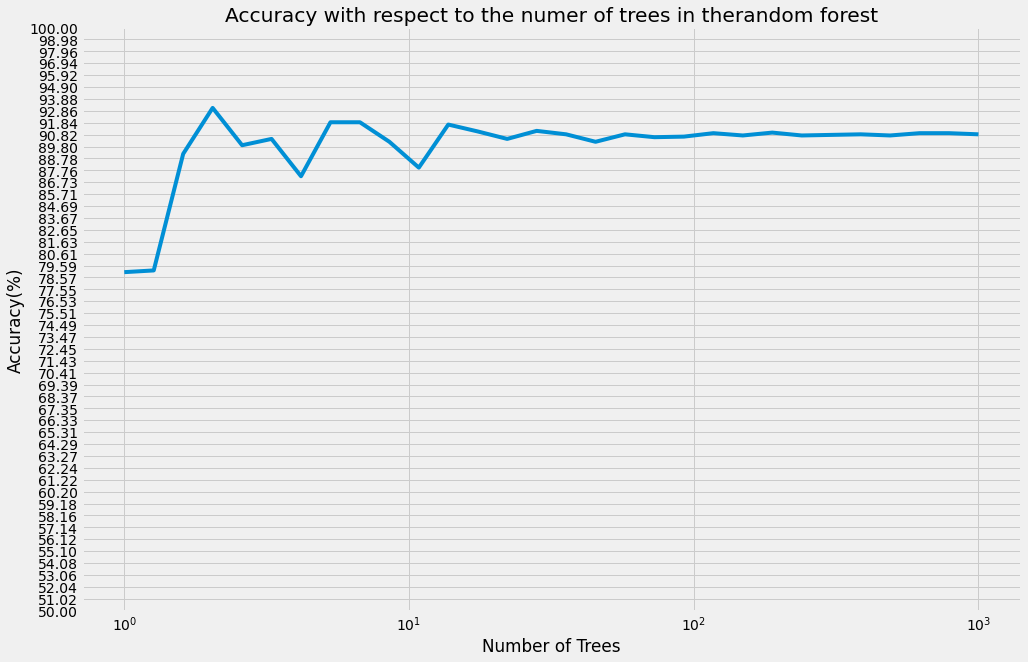

In [39]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(111)
accuracy = []
for i in range(1,11,1):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
for i in range(10,110,10):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
for i in range(100,1100,100):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
print(accuracy)
ax0.plot(np.logspace(0,3,30),accuracy)
ax0.set_yticks(np.linspace(50,100,50))
ax0.set_title("Accuracy with respect to the numer of trees in therandom forest")
ax0.set_xscale('log')
ax0.set_xlabel("Number of Trees")
ax0.set_ylabel('Accuracy(%)')
plt.show()


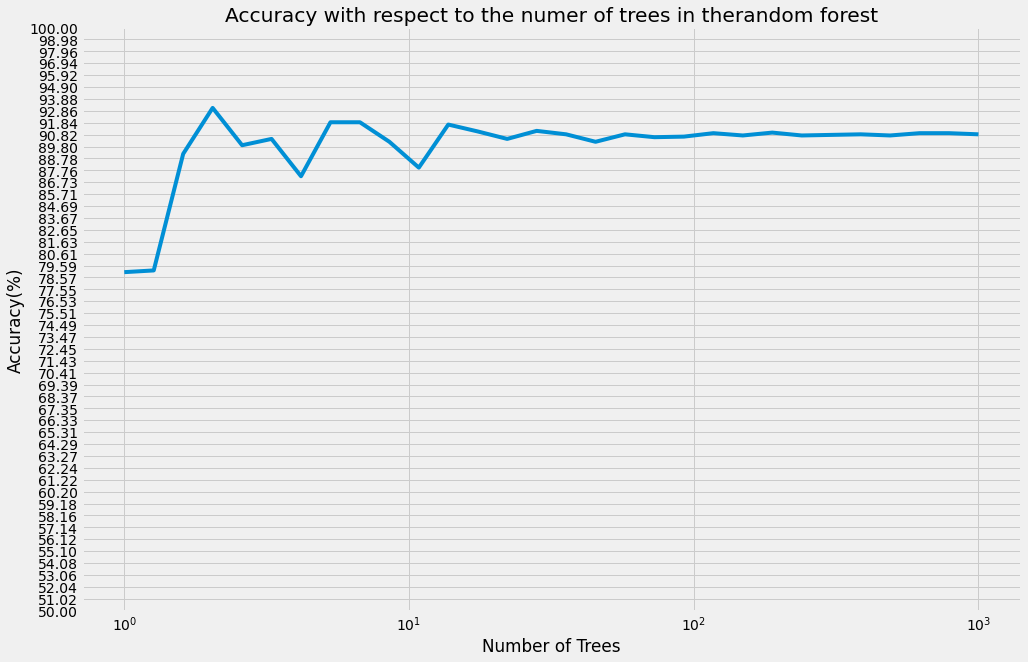

In [41]:
style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(111)
ax0.plot(np.logspace(0,3,30),accuracy)
ax0.set_yticks(np.linspace(50,100,50))
ax0.set_title("Accuracy with respect to the numer of trees in therandom forest")
ax0.set_xscale('log')
ax0.set_xlabel("Number of Trees")
ax0.set_ylabel('Accuracy(%)')
plt.show()